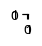

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import reconstruction_accuracy, VAELoss
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import CDR3bVAE
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# Some checks

In [394]:
%ls ../output/RedoTestKFOLD_readjustedWeights_rCSqS/RedoTestKFOLD_KFold_0_230927_1001_rCSqS

RedoTestKFOLD_KFold_0_230927_1001_rCSqS.png
args_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_RedoTestKFOLD_KFold_0_230927_1001_rCSqS.csv


In [396]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/RedoTestKFOLD_readjustedWeights_rCSqS/RedoTestKFOLD_KFold_{i}_230927_1001_rCSqS/args_RedoTestKFOLD_KFold_{i}_230927_1001_rCSqS.txt | tail -n 10


0
Best valid epoch: 1263
total:	0.15150960240612205
reconstruction:	0.1080471352777791
kld:	0.04346246641433629
seq_accuracy:	0.9669127464294434
v_accuracy:	0.993407130241394
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9664827390245643
Best valid V acc: 0.9910525076524606
Best valid J acc: 0.9931716505768778

1
Best valid epoch: 1655
total:	0.12759196008296647
reconstruction:	0.08932886639228978
kld:	0.038263092472320674
seq_accuracy:	0.9610089063644409
v_accuracy:	0.9945805668830872
j_accuracy:	0.9964656233787537
Fold: 1Best valid seq acc: 0.9607527810908173
Best valid V acc: 0.9915174363807728
Best valid J acc: 0.9967012252591895

2
Best valid epoch: 817
total:	0.16030763908957424
reconstruction:	0.11644548907156406
kld:	0.043862149119377136
seq_accuracy:	0.9571055769920349
v_accuracy:	0.9926972985267639
j_accuracy:	0.9941107034683228
Fold: 2Best valid seq acc: 0.9562349613830535
Best valid V acc: 0.992226148409894
Best valid J acc: 0.9945818610129564

3
Best valid epo

In [50]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/args_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.txt | tail -n 10


0
Fold: 0Best valid epoch: 575
total:	0.4113215639264493
reconstruction:	0.37363986051697323
kld:	0.037681700979748246
seq_accuracy:	0.9379920959472656
v_accuracy:	0.9218271970748901
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9381558377693086
Best valid V acc: 0.9215917117965623
Best valid J acc: 0.993407110901813

1
Fold: 1Best valid epoch: 674
total:	0.6807788295862699
reconstruction:	0.6456284207852802
kld:	0.0351504118170354
seq_accuracy:	0.9561837315559387
v_accuracy:	0.8152686357498169
j_accuracy:	0.9957587122917175
Fold: 1Best valid seq acc: 0.9566856574804349
Best valid V acc: 0.819038642789821
Best valid J acc: 0.9957587181903864

2
Fold: 2Best valid epoch: 795
total:	0.7249003094413676
reconstruction:	0.6897032166819129
kld:	0.03519708667349759
seq_accuracy:	0.9577098488807678
v_accuracy:	0.8235571384429932
j_accuracy:	0.9955241680145264
Fold: 2Best valid seq acc: 0.9571465191206466
Best valid V acc: 0.8235571260306243
Best valid J acc: 0.9967020023557126

3
F

Probly don't need to have that much weight on J gene but for V gene 2.5 seems good.

In [33]:
%ls ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.csv


In [3]:
# init stuff
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
# Re-init / write down params here ; Taken from the args.txt
max_len, encoding, pad_scale = 23, 'BL50LO', -20
cdr3b_col, v_col, j_col = 'B3', 'TRBV_gene', 'TRBJ_gene'
use_v, use_j, v_dim, j_dim = True, True, 51, 13
hidden_dim, latent_dim = 256, 128
lr, weight_decay = 5e-4, 1e-4
loss_weights = {'weight_seq':3, 'weight_kld':1, 'weight_v':2.5, 'weight_j':2}
n_epochs, batch_size = 2000, 256
# Remaking dataset-loaders
total_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map=None, j_map = None)
total_loader = total_dataset.get_dataloader(batch_size, RandomSampler)
test_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map= total_dataset.v_map, j_map = total_dataset.j_map)
test_loader = test_dataset.get_dataloader(batch_size, SequentialSampler)
folder = '../output/FirstTest_230926_1923_bb76k/'

In [ ]:
# Turns out, I didn't think that different partitions in the train dataset would have different v/j maps.
# As such, I need to save it here and reload it everytime (HARDCODED BAD BEHAVIOUR BUT NO WORKAROUND BECAUSE I NEED TO MAKE SURE THINGS MATCH BETWEEN FOLDS)
# Also need to fix the weights on seq/kld/v/j weights to 3, 2, 2.5, 1.5 ; For now, re-run the scripts and test stuff here and do inference.

In [44]:
pkl_dump(total_dataset.v_map, '../data/Matrices/230927_nettcr_dataset_vmap.pkl')
pkl_dump(total_dataset.j_map, '../data/Matrices/230927_nettcr_dataset_jmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_vmap.pkl saved.
/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_jmap.pkl saved.


# Reloading models and preds from KCV

In [45]:
models = {}
for i in range(5):
    fn = f'{folder}FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/checkpoint_best_fold{i:02}_kcv_230921_nettcr_immrepnegs_noswap_f{i:02}_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.pt'
    try:
        models[i] = load_checkpoint(CDR3bVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
    except:
        print(i)
        d = torch.load(fn)
        print(d['encoder.0.weight'].shape)
    # might as well retrain all folds with adjusted v/j/kld weights

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
0
torch.Size([261, 523])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
3
torch.Size([261, 523])


# Fixing the seq recons accuracy taking the pad instead of the actual sequence with the true lengths

In [72]:
sample = test_dataset.x[:5]
x_hat, _, _ = models[1](sample)


In [129]:
# Redo accuracy without padding
seq_true, v_true, j_true = models[1].reconstruct_hat(sample)
seq_hat, v_hat, j_hat = models[1].reconstruct_hat(x_hat)
# randomly change some indices so acc is not 100%
seq_hat[0,5:7]=3
seq_hat[1,6]=12
seq_hat[2, 0:7]=4

In [143]:
# NOTE : Fixed version with the true acc
def redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, pad_index=20, return_per_element=False):

    mask = (seq_true != pad_index).float()
    true_lens = mask.sum(dim=1)
    # masked_seq_true = seq_true*mask
    # masked_seq_hat = seq_hat*mask
    # difference here for per element is that we don't take the mean(dim=0) and have to detach() from graph to do tolist()
    seq_accuracy = ((seq_true == seq_hat).float() * mask).sum(1) / true_lens
    print(true_lens)
    print(mask)
    if return_per_element:
        seq_accuracy = seq_accuracy.detach().cpu().tolist()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
    else:
        seq_accuracy = seq_accuracy.mean(dim=0).item()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float().mean(dim=0)).item()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float().mean(dim=0)).item()
    return seq_accuracy, v_accuracy, j_accuracy
redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, 20, True)[0]

tensor([10., 12., 13., 13., 13.])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])


[0.800000011920929, 0.9166666865348816, 0.38461539149284363, 1.0, 1.0]

In [109]:
((seq_true==seq_hat).float() * mask).sum(1) / true_lengths

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [107]:
# Create a binary mask where 1 indicates non-padding values
mask = (seq_true != 20).float()

# Sum along the columns to get the true length for each row
true_lengths = mask.sum(dim=1)
# Apply the mask to both seq_true and seq_hat
masked_seq_true = seq_true * mask
masked_seq_hat = seq_hat * mask

# Calculate element-wise equality
reconstruction_accuracy = ((masked_seq_true == masked_seq_hat).float() * mask).sum(1) / true_lengths
reconstruction_accuracy

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [97]:
true_lengths

tensor([10., 12., 13., 13., 13.])

# inference using the reloaded models (missing 2 folds) 230927_1009

## With V/J genes

In [200]:
%ls ../output/FirstTest_230926_1923_bb76k/

FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/


In [205]:
next(filter(lambda x:'checkpoint' in x, os.listdir(fdir[0])))

'checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt'

In [206]:
sorted(fdir)

['../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/']

In [238]:
# reload all models now : 
maindir='../output/FirstTest_230926_1923_bb76k/'
fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store'])
models = {}
for i,fd in enumerate(fdirs):
    fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
    print(fn)
    models[i] = load_checkpoint(CDR3bVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)

../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/checkpoint_best_fold01_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/checkpoint_best_fold02_kcv_230921_nettcr_immrepnegs_noswap_f02_FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/checkpoint_best_fold03_kcv_230921_nettcr_immrepnegs_noswap_f03_FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt


In [247]:
from src.data_processing import AA_KEYS
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
test_df['flag'] = test_df['B3'].apply(lambda x: all([c in AA_KEYS for c in x]))
# Some filtering that I forgot to do before...
test_df = test_df.query('flag')
test_df = test_df.query('TRBV_gene in @V_MAP.keys() and TRBJ_gene in @J_MAP.keys()')
test_df = test_df.query('B3 not in @kcv_df.B3.unique()')
# Re-saving the filtered test set
test_df.to_csv('../data/filtered/230927_vdjdb_mcpas_filtered_concat_REDONE_cdr3b_vjgenes.csv', index=False)
test_dataset = CDR3BetaDataset(test_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
test_loader = test_dataset.get_dataloader(1024, SequentialSampler)

In [240]:
from src.metrics import reconstruction_accuracy
from src.data_processing import V_MAP, J_MAP
from src.datasets import CDR3BetaDataset

df_valid_0 = kcv_df.query('partition==0')
valid_dataset_0 = CDR3BetaDataset(df_valid_0, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_0 = valid_dataset_0.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_1 = kcv_df.query('partition==1')
valid_dataset_1 = CDR3BetaDataset(df_valid_1, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_1 = valid_dataset_1.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_2 = kcv_df.query('partition==2')
valid_dataset_2 = CDR3BetaDataset(df_valid_2, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_2 = valid_dataset_2.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_3 = kcv_df.query('partition==3')
valid_dataset_3 = CDR3BetaDataset(df_valid_3, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_3 = valid_dataset_3.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_4 = kcv_df.query('partition==4')
valid_dataset_4 = CDR3BetaDataset(df_valid_4, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_4 = valid_dataset_4.get_dataloader(batch_size=1024, sampler=SequentialSampler)

# Re-get predictions so that we get the correct accuracy now with the updated non-pad seq reconstruction accuracy
torch.manual_seed(0)
df_valid_0 = predict_model(models[0], valid_dataset_0, valid_loader_0)
df_test_0 = predict_model(models[0], test_dataset, test_loader)
torch.manual_seed(1)
df_valid_1 = predict_model(models[1], valid_dataset_1, valid_loader_1)
df_test_1 = predict_model(models[1], test_dataset, test_loader)
torch.manual_seed(2)
df_valid_2 = predict_model(models[2], valid_dataset_2, valid_loader_2)
df_test_2 = predict_model(models[2], test_dataset, test_loader)
torch.manual_seed(3)
df_valid_3 = predict_model(models[3], valid_dataset_3, valid_loader_3)
df_test_3 = predict_model(models[3], test_dataset, test_loader)
torch.manual_seed(4)
df_valid_4 = predict_model(models[4], valid_dataset_4, valid_loader_4)
df_test_4 = predict_model(models[4], test_dataset, test_loader)

del valid_dataset_0, valid_loader_0, valid_dataset_1, valid_loader_1, valid_dataset_2, valid_loader_2, valid_dataset_3, valid_loader_3, valid_dataset_4, valid_loader_4, test_dataset, test_loader

In [243]:
for fd, valid, test in zip(fdirs, [df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4], [df_test_0, df_test_1, df_test_2, df_test_3, df_test_4]):
    valid.to_csv(f'{fd}redo_valid.csv',index=False)
    test.to_csv(f'{fd}redo_test.csv',index=False)

In [391]:
model

FullFVAE(
  (encoder): Sequential(
    (0): Linear(in_features=524, out_features=262, bias=True)
    (1): SELU()
    (2): Linear(in_features=262, out_features=256, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=256, out_features=128, bias=True)
  (encoder_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SELU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=256, out_features=262, bias=True)
    (1): SELU()
    (2): Linear(in_features=262, out_features=460, bias=True)
  )
  (decoder_v): Linear(in_features=256, out_features=51, bias=True)
  (decoder_j): Linear(in_features=256, out_features=13, bias=True)
)

In [244]:
for df, n in zip([df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4, df_test_0, df_test_1, df_test_2, df_test_3, df_test_4],
                 ["z_valid_0", "z_valid_1", "z_valid_2", "z_valid_3", "z_valid_4", "z_test_0", "z_test_1", "z_test_2", "z_test_3", "z_test_4"]):
    print(n)
    print(f'Seq {df.seq_acc.mean():.2%}, V {df.v_correct.mean():.2%}, J {df.j_correct.mean():.2%}')


z_valid_0
Seq 91.40%, V 99.08%, J 99.34%
z_valid_1
Seq 92.90%, V 98.75%, J 99.62%
z_valid_2
Seq 93.22%, V 99.15%, J 99.69%
z_valid_3
Seq 92.27%, V 98.94%, J 99.22%
z_valid_4
Seq 91.89%, V 99.39%, J 99.03%
z_test_0
Seq 90.19%, V 98.12%, J 97.91%
z_test_1
Seq 91.48%, V 98.06%, J 98.38%
z_test_2
Seq 92.01%, V 98.46%, J 98.79%
z_test_3
Seq 90.86%, V 98.25%, J 98.11%
z_test_4
Seq 90.61%, V 98.44%, J 98.25%


In [245]:
# JUST DO THIS FOR NOW WITH THESE MODELS ; CHECK THE OTHER MODELS (REDO) later

## clustering stuff

In [5]:
from src.data_processing import V_MAP, J_MAP
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
# (top 10 + immrepnegs)
top11_pep = kcv_df.groupby(['peptide']).agg(count=('B3','count')).sort_values('count',ascending=False).head(11).index
top11_df = kcv_df.query('peptide in @top11_pep').reset_index(drop=True)
top11_dataset = CDR3BetaDataset(top11_df, max_len, encoding, pad_scale, cdr3b_col,  use_v, use_j, v_col, j_col, v_dim, j_dim, V_MAP, J_MAP)
top11_loader = top11_dataset.get_dataloader(1024, SequentialSampler)

### First, re-merge / process the kcv data to include CDR3 A and B from the raw files

In [343]:
%ls ../data/NetTCR

230919_nettcr_immrepnegs_merged_all.csv
230919_nettcr_immrepnegs_noswap.csv
95_redundancy_reduced_nettcr_train_mixed_negatives_ls_3_26_peptides_final.csv
anarci_annotated_new_df.csv
anarci_output.tsv
covid_controls/
negative_controls_95_redundancy_reduced.csv
nettcr_train_mathias.csv
new_train_df.csv


In [ ]:
# Annotation should come from Immrep and NetTCR/anarci_annotated_new_df

In [6]:
ndir = '../data/immrep/'
pos_annot = pd.read_csv('../data/NetTCR/anarci_output.tsv', sep = '\t')
neg_annot = pd.concat([pd.read_csv(f'{ndir}{f}', sep = '\t') for f in os.listdir(ndir)])[['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'TRA_CDR3', 'TRB_CDR3']]


In [7]:
kcv_df

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,immrep_negs,immrep_negs,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,immrep,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,immrep_negs,immrep_negs,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,immrep_negs,immrep_negs,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,immrep,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,immrep_negs,immrep_negs,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,immrep_negs,immrep_negs,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,TRAJ52*01,TRBV19*02,TRBJ1-2*01,4,36260.0,HLA-A*02:01,VDJdb,2580.0,TRBV19,TRBJ1-2
21213,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,TRAJ42*01,TRBV19*01,TRBJ2-5*01,2,36817.0,HLA-A*02:01,10x,5082.0,TRBV19,TRBJ2-5
21214,NSASDY,IRSNMDK,AENLGGGSQGNLI,LNHDA,SQIVND,ASSTRATGELF,1,GILGFVFTL,GILGFVFTL,TRAV13-2*01,TRAJ42*01,TRBV19*01,TRBJ2-2*01,3,36884.0,HLA-A*02:01,10x,6211.0,TRBV19,TRBJ2-2
21215,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,2,37310.0,HLA-A*02:01,VDJdb,4078.0,TRBV19,TRBJ2-1


In [8]:
kcv_positives = kcv_df.query('origin!= "immrep"').merge(pos_annot[['A1', 'A2', 'A3', 'B1','B2','B3', 'TRA_CDR3', 'TRB_CDR3']], 
                                                        left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3']).drop_duplicates(subset=['A1', 'A2', 'A3', 'B1','B2','B3'])
kcv_negatives = kcv_df.query('origin== "immrep"').merge(neg_annot[['A1', 'A2', 'A3', 'B1','B2','B3', 'TRA_CDR3', 'TRB_CDR3']], 
                                                        left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3']).drop_duplicates(subset=['A1', 'A2', 'A3', 'B1','B2','B3'])
kcv_reannotated = pd.concat([kcv_positives, kcv_negatives])

kcv_reannotated['TRAV_gene'] = kcv_reannotated['TRAV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
kcv_reannotated['TRAJ_gene'] = kcv_reannotated['TRAJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])


kcv_reannotated.to_csv('../data/filtered/230927_nettcr_immrepnegs_noswap_ANNOTATED_CDR3.csv', index=False)
kcv_positives.to_csv('../data/filtered/230927_nettcr_positives_only.csv', index=False)

In [9]:
# Save for GLIPH 2:
import random
kcv_reannotated['count'] = 1 #kcv_reannotated['peptide'].apply(lambda x: 
kcv_reannotated['subj_cdt'] = kcv_reannotated['peptide'].apply(lambda x: f'{random.randint(0,99):02}/{random.randint(0, 9999):04}:{x}')
kcv_reannotated[['TRB_CDR3', 'TRBV_gene', 'TRBJ_gene', 'TRA_CDR3', 'subj_cdt','count']].to_csv('../data/kcv_to_GLIPH.tsv', index=False,header=False, sep='\t')

In [421]:
kcv_reannotated.to_csv('../data/kcv_to_GLIPH_annotated.csv', index=False)
kcv_reannotated.query('binder==1').to_csv('../data/kcv_to_GLIPH_BINDERS_annotated.csv', index=False)
kcv_reannotated.query('binder==1')[['TRB_CDR3', 'TRBV_gene', 'TRBJ_gene', 'TRA_CDR3', 'subj_cdt','count']].to_csv('../data/kcv_to_GLIPH_BINDERS.tsv', index=False,header=False, sep='\t')

In [403]:
model_novj = CDR3bVAE(23,'BL50LO', pad_scale=-20, use_v=False, use_j=False)

In [416]:
kcv_positives['TRB_CDR3'].apply(len).max()

25

## GLIPH results

In [12]:
# Reload annotations:

gliph_all_annot = pd.read_csv('../data/GLIPH/save_to_gliph/kcv_to_gliph_annotated.csv')
gliph_pep_annot = pd.read_csv('../data/GLIPH/save_to_gliph/kcv_to_GLIPH_BINDERS_annotated.csv')
gliph_results_all = pd.read_csv('../data/GLIPH/gliph_results/P10622_BCNXUMRLJM.csv')
gliph_results_all.drop(columns = [x for x in gliph_results_all.columns if 'HLA' in x], inplace=True)
gliph_results_all.head()

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
0,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrsldIQYF,CASSIRSLDIQYF,TRBV19,TRBJ2-4,CAGTYGGSQGNLIF,75/5473:GILGFVFTL,1.0
1,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrSGNTEAF,CASSIRSGNTEAF,TRBV19,TRBJ1-1,CSPVGDGGSQGNLIF,70/9998:GILGFVFTL,1.0
2,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssNEQFF,CASSIRSSNEQFF,TRBV19,TRBJ2-1,CVVNYGGGSQGNLIF,37/7357:GILGFVFTL,1.0
3,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssETQYF,CASSIRSSETQYF,TRBV19,TRBJ2-5,CAVTRDDKIIF,05/2555:GILGFVFTL,1.0
4,1,SIRS,0.0,156,46,1.500000e-11,1.0,0.001,1.0,0.001,0.000015,motif-SIRS,CASSIrssETQYF,CASSIRSSETQYF,TRBV19,TRBJ2-5,CAAKSNTGKLIF,03/9283:GILGFVFTL,1.0


In [503]:
# Reload annotations:

gliph_pep_annot = pd.read_csv('../data/GLIPH/save_to_gliph/kcv_to_GLIPH_BINDERS_annotated.csv')
gliph_results_pos = pd.read_csv('../output/GLIPH/GLIPH_KCV_POS_ONLY.csv')
gliph_results_pos.drop(columns = [x for x in gliph_results_pos.columns if 'HLA' in x], inplace=True)
gliph_results_pos.head()

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
0,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsTGELF,CASSIRSTGELF,TRBV19,TRBJ2-2,CAVTYGGSQGNLIF,51/8030:GILGFVFTL,1.0
1,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsNTEAFF,CASSIRSNTEAFF,TRBV19,TRBJ1-1,CAGDSGGGSQGNLIF,99/1201:GILGFVFTL,1.0
2,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAGGGDGGSQGNLIF,83/6796:GILGFVFTL,1.0
3,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAESIGRGSQGNLIF,65/8923:GILGFVFTL,1.0
4,1,SIRS,0.0,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsddIQYF,CASSIRSDDIQYF,TRBV19,TRBJ2-4,CGTADGGSQGNLIF,59/6999:GILGFVFTL,1.0


In [507]:
gliph_results_pos.query('pattern!="single"')

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
0,1,SIRS,0.000,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsTGELF,CASSIRSTGELF,TRBV19,TRBJ2-2,CAVTYGGSQGNLIF,51/8030:GILGFVFTL,1.0
1,1,SIRS,0.000,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsNTEAFF,CASSIRSNTEAFF,TRBV19,TRBJ1-1,CAGDSGGGSQGNLIF,99/1201:GILGFVFTL,1.0
2,1,SIRS,0.000,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAGGGDGGSQGNLIF,83/6796:GILGFVFTL,1.0
3,1,SIRS,0.000,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrSGvEQYF,CASSIRSGVEQYF,TRBV19,TRBJ2-7,CAESIGRGSQGNLIF,65/8923:GILGFVFTL,1.0
4,1,SIRS,0.000,155,45,1.400000e-11,1.0,0.001,1.0,0.001,0.000014,motif-SIRS motif-IRS,CASSIrsddIQYF,CASSIRSDDIQYF,TRBV19,TRBJ2-4,CGTADGGSQGNLIF,59/6999:GILGFVFTL,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,633,S%GTDT,0.076,2,2,1.700000e-06,1.0,0.059,1.0,0.001,0.029000,global-S%GTDT,CASSLgTDTQYF,CASSLGTDTQYF,TRBV27,TRBJ2-3,CAASI,62/6684:ELAGIGILTV,1.0
3277,634,S%GE,0.079,2,2,1.700000e-06,1.0,0.058,1.0,0.001,0.029000,global-S%GE,CASSfgEQFF,CASSFGEQFF,TRBV7-2,TRBJ2-1,CVVLNTDKLIF,20/2811:GILGFVFTL,1.0
3278,634,S%GE,0.079,2,2,1.700000e-06,1.0,0.058,1.0,0.001,0.029000,global-S%GE,CASSVgEAFF,CASSVGEAFF,TRBV2,TRBJ1-1,CAVYGGATNKLIF,65/9762:RAKFKQLL,1.0
3279,635,SIF,0.130,2,2,4.000000e-04,1.0,0.076,1.0,0.180,0.029000,motif-SIF,CASSPGTSifvaEQYF,CASSPGTSIFVAEQYF,TRBV3-1,TRBJ2-7,CAVTPGTYKYIF,68/6833:ELAGIGILTV,1.0


In [505]:
gliph_results_pos.groupby(['index']).unique()

AttributeError: 'DataFrameGroupBy' object has no attribute 'unique'

## Results of training with CDR3b only

In [40]:
%ls ../output

230928_NotebookTests/
DEBUG_INIT_KFold_0_230926_1652_15lYT/
DEBUG_INIT_noV_noJ_KFold_0_230927_1553_None/
FirstTest_230926_1923_bb76k/
OnlyPosCDR3b_latent_64_wd_1e-3/
OnlyPosCDR3b_latent_64_wd_1e-4/
RedoTestKFOLD_readjustedWeights_rCSqS/
notebooks/


In [61]:
df['TRB_CDR3'].to_csv('../data/filtered/230928_NetTCR_CDR3B_pep.txt', index=False,header=False)

In [135]:
maindir

'../output/OnlyPosB3_latent_32_wd_1e-5_230928_1224_SY897/'

In [ ]:
maindirs = ['OnlyPosB3_latent_32_wd_1e-4_230928_1224_bYtbj', 'OnlyPosB3_latent_32_wd_1e-5_230928_1224_SY897', 'OnlyPosB3_latent_64_wd_1e-5_230928_1224_2Fxn5', 'OnlyPosCDR3b_latent_64_wd_1e-3_230928_1052_ouVRO', 'OnlyPosCDR3b_latent_64_wd_1e-4_230928_1052_QXmAq']
maindirs = ['../output/'+x+'/' for x in maindirs]
for maindir in maindirs:
    # reload all models now : 
    fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store' and os.path.isdir(f'{maindir}/{x}/')])
    max_len, encoding, pad_scale = 25, 'BL50LO', -20
    use_v, use_j, v_dim, j_dim = False, False, 0, 0 
    models = {}
    for i,fd in enumerate(fdirs):
        try:
            fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
        except:
            continue
        latent_dim = 32 if '32' in fn else 64 if '64' in fn else 128
        hidden_dim = 2*latent_dim
        print(fn)
        models[i] = load_checkpoint(CDR3bVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
        
    df = kcv_positives.reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=26, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    
    top10_pep = kcv_positives.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
    df = kcv_positives.query('peptide in @top10_pep').reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=10, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/TOP10PEP_KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)

In [ ]:
# TODO: OK here need to re-think this and apply also the clusters purity thing, for both allpeps and top10peps
maindirs = ['OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_B6jIc', 
            'OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_j0xLE', 
            #'OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_sr9Jl', #this one is empty actually
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-3_ClXaM', 
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_A0dGE', 
            'OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_3jETu']
    
maindirs = ['../output/'+x+'/' for x in maindirs]
all_results = {}
for maindir in maindirs:
    # reload all models now : 
    fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store' and os.path.isdir(f'{maindir}/{x}/')])
    if len(fdirs)==0:continue
    max_len, encoding, pad_scale = 25, 'BL50LO', -20
    use_v, use_j, v_dim, j_dim = False, False, 0, 0 
    models = {}
    all_preds = []
    for i,fd in enumerate(fdirs):
        try:
            fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
        except:
            continue
        latent_dim = 32 if '32' in fn else 64 if '64' in fn else 128
        hidden_dim = 2*latent_dim
        print(fn)
        models[i] = load_checkpoint(CDR3bVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
        preds_fn = f"{fd}{next(filter(lambda x:'valid_predictions' in x, os.listdir(fd)))}"
        all_preds.append(pd.read_csv(preds_fn))
    all_results[maindir] = pd.concat(all_preds)
    df = kcv_positives.reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='TRB_CDR3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)

    train_cluster_preds = []
    valid_cluster_preds = []
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=26, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)

        train_plot_df['partition']=fold
        valid_plot_df['partition']=fold
        train_cluster_preds.append(train_plot_df)
        valid_cluster_preds.append(valid_plot_df)
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    
    pd.concat(train_cluster_preds).to_csv(f'{maindir}/all_peps_train_cluster_preds.csv', index=False)
    pd.concat(valid_cluster_preds).to_csv(f'{maindir}/all_peps_valid_cluster_preds.csv', index=False)
    
    top10_pep = kcv_positives.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
    df = kcv_positives.query('peptide in @top10_pep').reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    train_cluster_preds = []
    valid_cluster_preds = []
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=10, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train, train_preds['TRB_CDR3'].values]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth', 'TRB_CDR3'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid, valid_preds['TRB_CDR3'].values]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth', 'TRB_CDR3'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)

        train_plot_df['partition']=fold
        valid_plot_df['partition']=fold
        train_cluster_preds.append(train_plot_df)
        valid_cluster_preds.append(valid_plot_df)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/TOP10PEP_KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    pd.concat(train_cluster_preds).to_csv(f'{maindir}/top10_peps_train_cluster_preds.csv', index=False)
    pd.concat(valid_cluster_preds).to_csv(f'{maindir}/top10_peps_valid_cluster_preds.csv', index=False)
    

In [ ]:
# TODO: OK here need to re-think this and apply also the clusters purity thing, for both allpeps and top10peps
maindirs = [x for x in os.listdir('../output/') if '10K' in x]
    
maindirs = ['../output/'+x+'/' for x in maindirs]
for maindir in maindirs:
    # reload all models now : 
    fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store' and os.path.isdir(f'{maindir}/{x}/')])
    if len(fdirs)==0:continue
    max_len, encoding, pad_scale = 25, 'BL50LO', -20
    use_v, use_j, v_dim, j_dim = False, False, 0, 0 
    models = {}
    all_preds = []
    for i,fd in enumerate(fdirs):
        try:
            fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
        except:
            continue
        latent_dim = 32 if '32' in fn else 64 if '64' in fn else 128
        hidden_dim = 2*latent_dim
        print(fn)
        models[i] = load_checkpoint(CDR3bVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
        preds_fn = f"{fd}{next(filter(lambda x:'valid_predictions' in x, os.listdir(fd)))}"
        all_preds.append(pd.read_csv(preds_fn))
    all_results[maindir] = pd.concat(all_preds)
    df = kcv_positives.reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='TRB_CDR3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)

    train_cluster_preds = []
    valid_cluster_preds = []
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=26, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)

        train_plot_df['partition']=fold
        valid_plot_df['partition']=fold
        train_cluster_preds.append(train_plot_df)
        valid_cluster_preds.append(valid_plot_df)
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    
    pd.concat(train_cluster_preds).to_csv(f'{maindir}/all_peps_train_cluster_preds.csv', index=False)
    pd.concat(valid_cluster_preds).to_csv(f'{maindir}/all_peps_valid_cluster_preds.csv', index=False)
    
    top10_pep = kcv_positives.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).head(10).index
    df = kcv_positives.query('peptide in @top10_pep').reset_index(drop=True)
    dataset = CDR3BetaDataset(df, max_len, encoding, pad_scale, cdr3b_col='B3', use_v=False, use_j=False, v_dim=0, j_dim=0)
    loader = dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)
    
    train_cluster_preds = []
    valid_cluster_preds = []
    for fold, model in tqdm(models.items()):
        train_idx = df.query('partition!=@fold').index
        valid_idx = df.query('partition==@fold').index
        
        preds = predict_model(model, dataset, loader)
        train_preds = preds.loc[train_idx]
        valid_preds = preds.loc[valid_idx]
        z_train = train_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_train = train_preds['peptide'].values
        z_valid = valid_preds[[f'z_{i}' for i in range(latent_dim)]].values
        labels_valid = valid_preds['peptide'].values
        km = KMeans(n_clusters=10, random_state=13)
        print('KM')
        train_clusters = km.fit_predict(z_train)
        valid_clusters = km.predict(z_valid)
        print('TSNE')
        tsne = TSNE(n_components=2, metric='l2', perplexity=25)
        # tsne = UMAP(n_components=2, learning_rate=0.1, metric='cosine', output_metric='cosine')
        
        latent_tsne = tsne.fit_transform(np.concatenate([z_train, z_valid], axis=0))
        tsne_train, tsne_valid = latent_tsne[:len(z_train)], latent_tsne[len(z_train):]
        
        print('Making DFs')
        train_plot_df = pd.DataFrame(data=np.stack([tsne_train[:,0], tsne_train[:, 1], train_clusters, labels_train, train_preds['TRB_CDR3'].values]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth', 'TRB_CDR3'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        train_plot_df['KMeans_Cluster'] = train_plot_df['KMeans_Cluster'].astype(str)
        valid_plot_df = pd.DataFrame(data=np.stack([tsne_valid[:,0], tsne_valid[:, 1], valid_clusters, labels_valid, valid_preds['TRB_CDR3'].values]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth', 'TRB_CDR3'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
        valid_plot_df['KMeans_Cluster'] = valid_plot_df['KMeans_Cluster'].astype(str)

        train_plot_df['partition']=fold
        valid_plot_df['partition']=fold
        train_cluster_preds.append(train_plot_df)
        valid_cluster_preds.append(valid_plot_df)
        
        f,a = plt.subplots(2,2, figsize=(25,25))
        sns.set_palette('gnuplot2_r', n_colors=7)
        f.suptitle(f'Fold {fold} ; t-SNE Visualization with K-Means Clusters on Latent (d=64) ; Only TRB_CDR3')
        a = a.ravel()
        pep_order = sorted(df.peptide.unique())
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'),
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[0])
        sns.scatterplot(data=train_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[1])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='KMeans_Cluster', hue_order=sorted(np.unique(train_clusters).astype(str)), ax = a[2])
        sns.scatterplot(data=valid_plot_df, #.query('GroundTruth!="immrep_negs"'), 
                        x='TSNE_1', y='TSNE_2',  s=13, hue='GroundTruth', hue_order=pep_order, ax = a[3])
        a[0].set_title('Train : Predicted clusters')
        a[1].set_title('Train : Ground Truth')
        a[2].set_title('Valid : Predicted clusters')
        a[3].set_title('Valid : Ground Truth')
        f.tight_layout()
        f.savefig(f'{maindir}/TOP10PEP_KFold_{fold}_latent_tsne_KMeans_only_TRB_CDR3', bbox_inches='tight', dpi=200)
    pd.concat(train_cluster_preds).to_csv(f'{maindir}/top10_peps_train_cluster_preds.csv', index=False)
    pd.concat(valid_cluster_preds).to_csv(f'{maindir}/top10_peps_valid_cluster_preds.csv', index=False)
    

In [208]:
for k,v in all_results.items():
    v.to_csv(f'../output/{k}_allFoldsConcat.csv',index=False)

In [529]:
from src.data_processing import encode_batch
sample = kcv_positives.sample(50)
cdr3 = encode_batch(sample['TRB_CDR3'], 25, 'BL50LO', -20)
peps = encode_batch(sample['peptide'], 12, 'BL50LO', -20)

In [540]:
cat_first = torch.cat([cdr3,peps], dim=1).flatten(1)
flat_first = torch.cat([cdr3.flatten(1), peps.flatten(1)], dim = 1)

In [523]:
xd = kcv_positives.copy()
xd.apply(lambda x: x['TRB_CDR3']+'AAA'+x['peptide'], axis=1)

0              CASGTETQYFAAAKLGGALQAK
1         CSARWGGGTDTQYFAAAELAGIGILTV
2        CSARGLDRGTNEQYFAAAAVFDRKSDAK
3       CASSPGTSIFVAEQYFAAAELAGIGILTV
4           CASSPGSRGNIQYFAAARAKFKQLL
                    ...              
6445         CASSIGYYGYTFAAAGILGFVFTL
6446        CASSFRSSETQYFAAAGILGFVFTL
6447        CASSTRATGELFFAAAGILGFVFTL
6448       CASSIRASGVEQFFAAAGILGFVFTL
6449    CASSQERGGKWAYEQYFAAAGILGFVFTL
Length: 6353, dtype: object

In [209]:
for k,v in all_results.items():
    print(k)
    gb=v.groupby(['partition']).agg(mean_acc=('seq_acc','mean'))
    print(f"Mean Acc: {gb.mean().item():.2%},\nMax Acc:{gb.max().item():.2%},\nMin Acc:{gb.min().item():.2%},\nStd Acc:{gb.std().item():.2%}")
    print('\n')

../output/OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_B6jIc/
Mean Acc: 87.69%,
Max Acc:91.75%,
Min Acc:78.51%,
Std Acc:5.64%


../output/OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_j0xLE/
Mean Acc: 87.69%,
Max Acc:91.75%,
Min Acc:78.51%,
Std Acc:5.64%


../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-3_ClXaM/
Mean Acc: 83.79%,
Max Acc:86.50%,
Min Acc:81.64%,
Std Acc:2.01%


../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_A0dGE/
Mean Acc: 95.48%,
Max Acc:96.74%,
Min Acc:93.56%,
Std Acc:1.18%


../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_3jETu/
Mean Acc: 95.48%,
Max Acc:96.74%,
Min Acc:93.56%,
Std Acc:1.18%


../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_LKzfT/
Mean Acc: 91.75%,
Max Acc:95.26%,
Min Acc:84.14%,
Std Acc:4.49%


../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_xjSWl/
Mean Acc: 91.75%,
Max Acc:95.26%,
Min Acc:84.14%,
Std Acc:4.49%


../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/
Mean Acc: 97.38%,
Max Acc

In [210]:
train_cluster_preds[0].groupby('GroundTruth').count()

,TSNE_1,TSNE_2,KMeans_Cluster,TRB_CDR3,partition
GroundTruth,,,,,
AVFDRKSDAK,572,572,572,572,572
CINGVCWTV,181,181,181,181,181
ELAGIGILTV,340,340,340,340,340
GILGFVFTL,900,900,900,900,900
GLCTLVAML,170,170,170,170,170
IVTDFSVIK,246,246,246,246,246
KLGGALQAK,722,722,722,722,722
LLWNGPMAV,184,184,184,184,184
NLVPMVATV,264,264,264,264,264


In [316]:
train_cluster_preds[0].partition.unique()[0]

0

In [456]:
def get_cluster_stats(input_df, cluster='KMeans_Cluster', label='GroundTruth', feature='TSNE_1', kf=True):

    if kf:
        summaries = []
        dfs = []
        for fold in input_df.partition.unique():
            df = input_df.query('partition==@fold')
            df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
            summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
            cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
            df = df.set_index([cluster, label])
            df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
            summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
            summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
            df.reset_index([label], inplace=True)
            df['cluster_size'] = summary['cluster_size']
            df['cluster_label'] = summary[label]
            df.reset_index(inplace=True)
            df.set_index([cluster, label], inplace=True)
            summary['partition'] = fold
            df['partition']=fold
            summaries.append(summary)
            dfs.append(df)
        return pd.concat(summaries), pd.concat(dfs)
    else:
        df = input_df
        df = df.groupby([cluster, label]).agg(count=(feature, 'count')).reset_index()
        summary = df.loc[df.groupby([cluster])['count'].idxmax(), [cluster, label]]
        cluster_sizes = df.groupby([cluster]).agg(cluster_size=('count','sum'))
        df = df.set_index([cluster, label])
        df['intra_cluster_percent'] = df['count'] / cluster_sizes['cluster_size'] * 100
        summary['purity_percent'] = summary.apply(lambda x: df.loc[x[cluster], x[label]]['intra_cluster_percent'], axis=1)
        summary = pd.merge(summary, cluster_sizes.reset_index(), left_on=[cluster], right_on=[cluster])
        df.reset_index([label], inplace=True)
        df['cluster_size'] = summary['cluster_size']
        df['cluster_label'] = summary[label]
        df.reset_index(inplace=True)
        df.set_index([cluster, label], inplace=True)
        summary['partition'] = 'ALL'
        df['partition']= 'ALL'
        return summary, df

In [363]:
get_cluster_stats(pd.concat(train_cluster_preds))[0]

,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition
0,0,GILGFVFTL,52.793296,358,0
1,1,GILGFVFTL,28.076923,260,0
2,2,KLGGALQAK,18.067227,476,0
3,3,RAKFKQLL,24.387255,816,0
4,4,RAKFKQLL,20.296296,675,0
5,5,KLGGALQAK,20.987654,405,0
6,6,GILGFVFTL,38.848921,695,0
7,7,RAKFKQLL,18.237705,488,0
8,8,KLGGALQAK,22.727273,110,0
9,9,GILGFVFTL,30.232558,43,0


In [485]:
pd.read_csv('../output/cluster_analysis/top10_peps_train_NnzVv_summary.csv')

,Unnamed: 0,KMeans_Cluster,GroundTruth,purity_percent,cluster_size,partition
0,0,0,GILGFVFTL,48.622366,617,0
1,1,1,RAKFKQLL,35.127479,353,0
2,2,2,GILGFVFTL,28.185328,259,0
3,3,3,AVFDRKSDAK,16.501650,303,0
4,4,4,RAKFKQLL,21.003717,538,0
5,5,5,KLGGALQAK,21.029083,447,0
6,6,6,RAKFKQLL,20.534459,711,0
7,7,7,KLGGALQAK,22.147651,149,0
8,8,8,KLGGALQAK,21.682243,535,0
9,9,9,GILGFVFTL,37.439614,414,0


In [512]:
maindirs = [x for x in os.listdir('../output/') if '10K' in x or 'OnlyPositivesFullCDR' in x]
maindirs = ['../output/'+x+'/' for x in maindirs]
outdir = '../output/cluster_analysis/'
for maindir in maindirs:
    files = sorted(list(filter(lambda x:'clust' in x and x.endswith('csv'), os.listdir(maindirs[0]) )))
    if len(files)!=4:print(maindir);continue
    print(maindir)
    for f in files:
        df = pd.read_csv(f'{maindir}{f}')
        fn = f.split('_clust')[0] +'_'+ maindir.split('_')[-1][:-1]
        summary, df = get_cluster_stats(df)
        summary.to_csv(f'{outdir}{fn}_summary.csv')
        df.to_csv(f'{outdir}{fn}_df.csv')
        print(fn)
        display(print(summary))

../output/OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_B6jIc/
all_peps_train_B6jIc
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       18.656716           134          0
1                1   KLGGALQAK       19.218241           307          0
2                2   KLGGALQAK       15.979381           194          0
3                3   KLGGALQAK       19.607843           204          0
4                4   KLGGALQAK       18.677043           257          0
..             ...         ...             ...           ...        ...
21              21   KLGGALQAK       16.494845            97          4
22              22    RAKFKQLL       17.123288           146          4
23              23   GILGFVFTL       25.641026            39          4
24              24    RAKFKQLL       29.166667           192          4
25              25    RAKFKQLL       46.341463           164          4

[130 rows x 5 columns]


None

all_peps_valid_B6jIc
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       25.000000            48          0
1                1   KLGGALQAK       23.333333            90          0
2                2   KLGGALQAK       15.384615            39          0
3                3  AVFDRKSDAK       17.142857            35          0
4                4    RAKFKQLL       18.965517            58          0
..             ...         ...             ...           ...        ...
21              21   KLGGALQAK       20.000000            20          4
22              22    RAKFKQLL       21.875000            32          4
23              23   GILGFVFTL       36.363636            11          4
24              24   GILGFVFTL       22.448980            49          4
25              25    RAKFKQLL       45.614035            57          4

[130 rows x 5 columns]


None

top10_peps_train_B6jIc
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0  AVFDRKSDAK       19.075145           173          0
1               1   KLGGALQAK       23.364486           107          0
2               2    RAKFKQLL       19.004525           442          0
3               3   KLGGALQAK       20.273973           730          0
4               4    RAKFKQLL       38.489209           278          0
5               5   GILGFVFTL       27.340824           267          0
6               6   KLGGALQAK       17.735043           468          0
7               7    RAKFKQLL       20.050441           793          0
8               8   GILGFVFTL       44.444444          1026          0
9               9   GILGFVFTL       30.952381            42          0
0               0    RAKFKQLL       24.261603           474          1
1               1    RAKFKQLL       19.783784           925          1
2               2   KLGGALQAK       18.408736         

None

top10_peps_valid_B6jIc
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   KLGGALQAK       21.052632            57          0
1               1   KLGGALQAK       37.500000            32          0
2               2   KLGGALQAK       21.428571           126          0
3               3  AVFDRKSDAK       18.404908           163          0
4               4    RAKFKQLL       33.870968            62          0
5               5  AVFDRKSDAK       20.588235            68          0
6               6   KLGGALQAK       19.047619           126          0
7               7    RAKFKQLL       21.142857           175          0
8               8   GILGFVFTL       42.641509           265          0
9               9   GILGFVFTL       25.000000             8          0
0               0    RAKFKQLL       26.446281           121          1
1               1    RAKFKQLL       24.444444           225          1
2               2    RAKFKQLL       20.370370         

None

../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_LKzfT/
all_peps_train_LKzfT
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   GILGFVFTL       50.617284            81          0
1                1   GILGFVFTL       25.477707           157          0
2                2   KLGGALQAK       10.795455           176          0
3                3   KLGGALQAK       20.325203           246          0
4                4    RAKFKQLL       23.195876           194          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       36.986301           292          4
22              22    RAKFKQLL       15.714286           140          4
23              23   KLGGALQAK       17.647059           255          4
24              24    RAKFKQLL       19.444444            36          4
25              25   GILGFVFTL       50.344828           145          4

[130 rows x 5 columns]


None

all_peps_valid_LKzfT
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   GILGFVFTL       47.058824            17          0
1                1   GILGFVFTL       47.222222            36          0
2                2    RAKFKQLL       13.793103            58          0
3                3   GILGFVFTL       18.461538            65          0
4                4   KLGGALQAK       27.500000            40          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       50.000000            66          4
22              22   GILGFVFTL       20.000000            40          4
23              23    RAKFKQLL       22.388060            67          4
24              24  AVFDRKSDAK       25.000000             8          4
25              25   GILGFVFTL       42.105263            38          4

[130 rows x 5 columns]


None

top10_peps_train_LKzfT
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       30.952381            42          0
1               1   GILGFVFTL       27.331887           461          0
2               2    RAKFKQLL       19.360568           563          0
3               3   KLGGALQAK       18.055556           648          0
4               4   KLGGALQAK       18.431373           510          0
5               5   KLGGALQAK       23.364486           107          0
6               6    RAKFKQLL       31.810193           569          0
7               7   KLGGALQAK       19.170984           579          0
8               8   GILGFVFTL       27.819549           266          0
9               9   GILGFVFTL       56.798623           581          0
0               0   GILGFVFTL       32.889734           526          1
1               1    RAKFKQLL       18.804665           686          1
2               2   GILGFVFTL       27.480916         

None

top10_peps_valid_LKzfT
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       25.000000             8          0
1               1   GILGFVFTL       33.057851           121          0
2               2   KLGGALQAK       18.604651           129          0
3               3   KLGGALQAK       20.000000           175          0
4               4   KLGGALQAK       21.481481           135          0
5               5   KLGGALQAK       37.500000            32          0
6               6    RAKFKQLL       28.057554           139          0
7               7  AVFDRKSDAK       16.406250           128          0
8               8   GILGFVFTL       21.212121            66          0
9               9   GILGFVFTL       49.664430           149          0
0               0   GILGFVFTL       36.956522           138          1
1               1    RAKFKQLL       18.079096           177          1
2               2   GILGFVFTL       25.000000         

None

../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_A0dGE/
all_peps_train_A0dGE
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       24.607330           191          0
1                1    RAKFKQLL       19.531250           256          0
2                2    RAKFKQLL       21.500000           200          0
3                3   KLGGALQAK       14.024390           164          0
4                4    RAKFKQLL       19.251337           187          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       35.256410           156          4
22              22   GLCTLVAML       18.348624           109          4
23              23   IVTDFSVIK       72.368421            76          4
24              24   KLGGALQAK       18.141593           226          4
25              25   KLGGALQAK       18.181818           209          4

[130 rows x 5 columns]


None

all_peps_valid_A0dGE
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       29.787234            47          0
1                1   GILGFVFTL       16.393443            61          0
2                2    RAKFKQLL       25.000000            60          0
3                3   KLGGALQAK       17.500000            40          0
4                4   KLGGALQAK       24.444444            45          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       36.111111            36          4
22              22   GILGFVFTL       20.588235            34          4
23              23   IVTDFSVIK       57.142857            14          4
24              24   KLGGALQAK       22.535211            71          4
25              25    RAKFKQLL       17.543860            57          4

[130 rows x 5 columns]


None

top10_peps_train_A0dGE
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0    RAKFKQLL       29.776675           403          0
1               1   GILGFVFTL       27.177700           287          0
2               2   IVTDFSVIK       19.113573           361          0
3               3   GILGFVFTL       50.602410           747          0
4               4   GILGFVFTL       28.185328           259          0
5               5   KLGGALQAK       21.149425           435          0
6               6   KLGGALQAK       18.461538           390          0
7               7    RAKFKQLL       21.568627           714          0
8               8   KLGGALQAK       20.309811           581          0
9               9   KLGGALQAK       22.147651           149          0
0               0   KLGGALQAK       19.680000           625          1
1               1    RAKFKQLL       20.299145           468          1
2               2   GILGFVFTL       26.235741         

None

top10_peps_valid_A0dGE
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0    RAKFKQLL       26.436782            87          0
1               1   GILGFVFTL       26.027397            73          0
2               2   IVTDFSVIK       20.000000            95          0
3               3   GILGFVFTL       48.186528           193          0
4               4   GILGFVFTL       22.388060            67          0
5               5   KLGGALQAK       27.826087           115          0
6               6  AVFDRKSDAK       19.166667           120          0
7               7    RAKFKQLL       23.602484           161          0
8               8  AVFDRKSDAK       18.320611           131          0
9               9   KLGGALQAK       32.500000            40          0
0               0   KLGGALQAK       20.422535           142          1
1               1    RAKFKQLL       25.862069           116          1
2               2   GILGFVFTL       23.437500         

None

../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_3jETu/
all_peps_train_3jETu
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       20.942408           191          0
1                1   KLGGALQAK       17.226891           238          0
2                2   KLGGALQAK       18.699187           246          0
3                3   GILGFVFTL       14.917127           181          0
4                4    RAKFKQLL       20.725389           193          0
..             ...         ...             ...           ...        ...
21              21  AVFDRKSDAK       19.387755            98          4
22              22   GILGFVFTL       14.009662           207          4
23              23   KLGGALQAK       16.727273           275          4
24              24    RAKFKQLL       42.105263            76          4
25              25   KLGGALQAK       20.000000           270          4

[130 rows x 5 columns]


None

all_peps_valid_3jETu
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       25.862069            58          0
1                1   LLWNGPMAV       23.809524            63          0
2                2   KLGGALQAK       20.634921            63          0
3                3  AVFDRKSDAK       16.216216            37          0
4                4    RAKFKQLL       25.000000            40          0
..             ...         ...             ...           ...        ...
21              21  AVFDRKSDAK       12.500000            24          4
22              22   GILGFVFTL       15.789474            76          4
23              23  AVFDRKSDAK       20.000000            85          4
24              24    RAKFKQLL       46.153846            13          4
25              25   KLGGALQAK       20.000000            75          4

[130 rows x 5 columns]


None

top10_peps_train_3jETu
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0    RAKFKQLL       30.806846           409          0
1               1   KLGGALQAK       20.366133           437          0
2               2   GILGFVFTL       27.304965           282          0
3               3   KLGGALQAK       20.588235           612          0
4               4   IVTDFSVIK       19.596542           347          0
5               5   GILGFVFTL       50.466045           751          0
6               6    RAKFKQLL       21.526718           655          0
7               7   KLGGALQAK       19.058824           425          0
8               8   KLGGALQAK       22.147651           149          0
9               9   GILGFVFTL       28.185328           259          0
0               0    RAKFKQLL       21.666667           420          1
1               1   KLGGALQAK       24.935065           385          1
2               2   GILGFVFTL       31.227437         

None

top10_peps_valid_3jETu
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0    RAKFKQLL       26.966292            89          0
1               1   KLGGALQAK       26.271186           118          0
2               2   GILGFVFTL       25.675676            74          0
3               3  AVFDRKSDAK       17.647059           136          0
4               4   IVTDFSVIK       20.224719            89          0
5               5   GILGFVFTL       48.186528           193          0
6               6    RAKFKQLL       22.368421           152          0
7               7   KLGGALQAK       18.548387           124          0
8               8   KLGGALQAK       32.500000            40          0
9               9   GILGFVFTL       22.388060            67          0
0               0    RAKFKQLL       29.411765           102          1
1               1    RAKFKQLL       18.181818            88          1
2               2   GILGFVFTL       35.333333         

None

../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-4_xjSWl/
all_peps_train_xjSWl
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       22.988506           174          0
1                1   KLGGALQAK       16.666667           216          0
2                2   KLGGALQAK       18.942731           227          0
3                3   KLGGALQAK       18.536585           205          0
4                4   KLGGALQAK       13.851351           296          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       41.433022           321          4
22              22   GILGFVFTL       23.255814            43          4
23              23   KLGGALQAK       18.098160           326          4
24              24   GILGFVFTL       36.496350           137          4
25              25   KLGGALQAK       17.714286           175          4

[130 rows x 5 columns]


None

all_peps_valid_xjSWl
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       23.529412            51          0
1                1   KLGGALQAK       20.454545            44          0
2                2  ELAGIGILTV       21.568627            51          0
3                3   GILGFVFTL       18.867925            53          0
4                4    RAKFKQLL       18.055556            72          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       47.692308            65          4
22              22   GILGFVFTL       36.363636            11          4
23              23    RAKFKQLL       20.000000            85          4
24              24   GILGFVFTL       26.470588            34          4
25              25   KLGGALQAK       18.750000            32          4

[130 rows x 5 columns]


None

top10_peps_train_xjSWl
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   KLGGALQAK       20.518359           463          0
1               1   GILGFVFTL       49.492672           887          0
2               2    RAKFKQLL       19.893428           563          0
3               3   GILGFVFTL       27.340824           267          0
4               4   KLGGALQAK       23.364486           107          0
5               5    RAKFKQLL       28.677840           537          0
6               6   KLGGALQAK       20.972644           329          0
7               7   KLGGALQAK       18.110236           635          0
8               8    RAKFKQLL       20.766129           496          0
9               9   GILGFVFTL       30.952381            42          0
0               0   KLGGALQAK       19.473684           190          1
1               1   GILGFVFTL       57.761733           554          1
2               2   GILGFVFTL       24.854369         

None

top10_peps_valid_xjSWl
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   KLGGALQAK       26.050420           119          0
1               1   GILGFVFTL       48.868778           221          0
2               2    RAKFKQLL       20.000000           110          0
3               3   GILGFVFTL       21.212121            66          0
4               4   KLGGALQAK       37.500000            32          0
5               5    RAKFKQLL       27.049180           122          0
6               6    RAKFKQLL       21.276596            94          0
7               7   KLGGALQAK       19.428571           175          0
8               8    RAKFKQLL       20.000000           135          0
9               9   GILGFVFTL       25.000000             8          0
0               0  AVFDRKSDAK       22.857143            35          1
1               1   GILGFVFTL       69.421488           121          1
2               2   GILGFVFTL       28.571429         

None

../output/OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-3_ClXaM/
all_peps_train_ClXaM
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       19.512195           164          0
1                1   KLGGALQAK       16.317992           239          0
2                2   GILGFVFTL       27.391304           230          0
3                3  AVFDRKSDAK       14.093960           149          0
4                4   GILGFVFTL       16.528926           121          0
..             ...         ...             ...           ...        ...
21              21    RAKFKQLL       53.359684           253          4
22              22  AVFDRKSDAK       15.246637           223          4
23              23   GILGFVFTL       23.737374           198          4
24              24   GILGFVFTL       43.307087           127          4
25              25   GILGFVFTL       23.809524            42          4

[130 rows x 5 columns]


None

all_peps_valid_ClXaM
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       29.545455            44          0
1                1  ELAGIGILTV       16.326531            49          0
2                2   GILGFVFTL       33.333333            54          0
3                3   KLGGALQAK       15.384615            52          0
4                4   CINGVCWTV       13.793103            29          0
..             ...         ...             ...           ...        ...
21              21    RAKFKQLL       50.000000            70          4
22              22    RAKFKQLL       21.428571            56          4
23              23   GILGFVFTL       18.367347            49          4
24              24   GILGFVFTL       51.851852            27          4
25              25   GILGFVFTL       41.666667            12          4

[129 rows x 5 columns]


None

top10_peps_train_ClXaM
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0    RAKFKQLL       18.727915           566          0
1               1   GILGFVFTL       32.960894           537          0
2               2   KLGGALQAK       16.435185           432          0
3               3   GILGFVFTL       27.443609           266          0
4               4    RAKFKQLL       26.918075           769          0
5               5   KLGGALQAK       22.727273           110          0
6               6   KLGGALQAK       20.421394           617          0
7               7   GILGFVFTL       56.136821           497          0
8               8   GILGFVFTL       30.232558            43          0
9               9   KLGGALQAK       18.200409           489          0
0               0   GILGFVFTL       61.227787           619          1
1               1    RAKFKQLL       17.375887           564          1
2               2   GILGFVFTL       27.500000         

None

top10_peps_valid_ClXaM
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   KLGGALQAK       23.489933           149          0
1               1   GILGFVFTL       32.692308           156          0
2               2  AVFDRKSDAK       18.348624           109          0
3               3   GILGFVFTL       22.388060            67          0
4               4    RAKFKQLL       26.250000           160          0
5               5   KLGGALQAK       37.500000            32          0
6               6   KLGGALQAK       16.666667           144          0
7               7   GILGFVFTL       54.954955           111          0
8               8   IVTDFSVIK       33.333333             9          0
9               9    RAKFKQLL       17.931034           145          0
0               0   GILGFVFTL       69.736842           152          1
1               1    RAKFKQLL       21.387283           173          1
2               2   GILGFVFTL       40.000000         

None

../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-5_NnzVv/
all_peps_train_NnzVv
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       19.631902           163          0
1                1    RAKFKQLL       17.880795           302          0
2                2    RAKFKQLL       22.543353           173          0
3                3   KLGGALQAK       16.326531           147          0
4                4   KLGGALQAK       17.672414           232          0
..             ...         ...             ...           ...        ...
21              21    RAKFKQLL       22.424242           165          4
22              22   GILGFVFTL       24.311927           218          4
23              23    RAKFKQLL       47.093023           172          4
24              24    RAKFKQLL       39.204545           176          4
25              25  AVFDRKSDAK       19.387755            98          4

[130 rows x 5 columns]


None

all_peps_valid_NnzVv
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       30.952381            42          0
1                1    RAKFKQLL       20.000000            70          0
2                2    RAKFKQLL       34.090909            44          0
3                3   KLGGALQAK       18.750000            32          0
4                4   GILGFVFTL       24.489796            49          0
..             ...         ...             ...           ...        ...
21              21  AVFDRKSDAK       16.216216            37          4
22              22    RAKFKQLL       34.210526            38          4
23              23    RAKFKQLL       44.444444            54          4
24              24    RAKFKQLL       40.000000            45          4
25              25  AVFDRKSDAK       12.500000            24          4

[130 rows x 5 columns]


None

top10_peps_train_NnzVv
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       48.622366           617          0
1               1    RAKFKQLL       35.127479           353          0
2               2   GILGFVFTL       28.185328           259          0
3               3  AVFDRKSDAK       16.501650           303          0
4               4    RAKFKQLL       21.003717           538          0
5               5   KLGGALQAK       21.029083           447          0
6               6    RAKFKQLL       20.534459           711          0
7               7   KLGGALQAK       22.147651           149          0
8               8   KLGGALQAK       21.682243           535          0
9               9   GILGFVFTL       37.439614           414          0
0               0   KLGGALQAK       19.418758           757          1
1               1   GILGFVFTL       26.923077           260          1
2               2   GILGFVFTL       18.197574         

None

top10_peps_valid_NnzVv
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       42.948718           156          0
1               1    RAKFKQLL       33.333333            72          0
2               2   GILGFVFTL       22.058824            68          0
3               3    RAKFKQLL       17.894737            95          0
4               4   KLGGALQAK       19.000000           100          0
5               5   KLGGALQAK       25.000000           128          0
6               6    RAKFKQLL       18.947368           190          0
7               7   KLGGALQAK       32.500000            40          0
8               8  AVFDRKSDAK       17.355372           121          0
9               9   GILGFVFTL       40.178571           112          0
0               0    RAKFKQLL       19.672131           183          1
1               1   GILGFVFTL       24.615385            65          1
2               2   GILGFVFTL       19.708029         

None

../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-4_x8CyX/
all_peps_train_x8CyX
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0  ELAGIGILTV       20.218579           183          0
1                1   GILGFVFTL       74.180328           244          0
2                2   KLGGALQAK       20.212766           188          0
3                3   KLGGALQAK       19.791667           192          0
4                4   KLGGALQAK       19.855596           277          0
..             ...         ...             ...           ...        ...
21              21   KLGGALQAK       19.230769           208          4
22              22  AVFDRKSDAK       19.101124            89          4
23              23    RAKFKQLL       14.666667            75          4
24              24   KLGGALQAK       18.320611           262          4
25              25    RAKFKQLL       14.545455           165          4

[130 rows x 5 columns]


None

all_peps_valid_x8CyX
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0  ELAGIGILTV       28.947368            38          0
1                1   GILGFVFTL       67.346939            49          0
2                2   KLGGALQAK       22.641509            53          0
3                3   GILGFVFTL       28.301887            53          0
4                4   GILGFVFTL       16.666667            78          0
..             ...         ...             ...           ...        ...
21              21   KLGGALQAK       18.181818            44          4
22              22  AVFDRKSDAK       12.500000            24          4
23              23  AVFDRKSDAK       21.428571            14          4
24              24   KLGGALQAK       18.181818            66          4
25              25    RAKFKQLL       18.181818            44          4

[130 rows x 5 columns]


None

top10_peps_train_x8CyX
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       56.399132           461          0
1               1   KLGGALQAK       20.168067           476          0
2               2   GILGFVFTL       20.071685           279          0
3               3    RAKFKQLL       19.323671           621          0
4               4    RAKFKQLL       20.822943           802          0
5               5   GILGFVFTL       28.185328           259          0
6               6    RAKFKQLL       23.875969           645          0
7               7   KLGGALQAK       22.147651           149          0
8               8   GILGFVFTL       46.333333           300          0
9               9  AVFDRKSDAK       17.964072           334          0
0               0   KLGGALQAK       20.610687           524          1
1               1    RAKFKQLL       23.353293           334          1
2               2   GILGFVFTL       52.747253         

None

top10_peps_valid_x8CyX
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       47.008547           117          0
1               1   KLGGALQAK       26.771654           127          0
2               2   GILGFVFTL       24.691358            81          0
3               3  AVFDRKSDAK       16.279070           129          0
4               4   KLGGALQAK       18.957346           211          0
5               5   GILGFVFTL       22.388060            67          0
6               6    RAKFKQLL       26.666667           135          0
7               7   KLGGALQAK       32.500000            40          0
8               8   GILGFVFTL       50.684932            73          0
9               9    RAKFKQLL       17.647059           102          0
0               0   KLGGALQAK       19.841270           126          1
1               1  AVFDRKSDAK       19.811321           106          1
2               2   GILGFVFTL       64.000000         

None

../output/10K_epochs_OnlyPositivesFullCDR3b_LowerDim_64_WD_1e-3_6dCWf/
all_peps_train_6dCWf
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       19.531250           128          0
1                1   GILGFVFTL       20.689655            87          0
2                2   GILGFVFTL       36.065574           183          0
3                3   KLGGALQAK       19.337017           181          0
4                4   KLGGALQAK       17.465753           292          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       54.320988            81          4
22              22   KLGGALQAK       19.289340           197          4
23              23   KLGGALQAK       23.364486           214          4
24              24   GILGFVFTL       28.402367           169          4
25              25    RAKFKQLL       16.086957           230          4

[130 rows x 5 columns]


None

all_peps_valid_6dCWf
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0   KLGGALQAK       33.333333            36          0
1                1  ELAGIGILTV       16.000000            25          0
2                2   GILGFVFTL       44.897959            49          0
3                3  AVFDRKSDAK       22.448980            49          0
4                4   GILGFVFTL       16.981132            53          0
..             ...         ...             ...           ...        ...
21              21   GILGFVFTL       53.846154            13          4
22              22   KLGGALQAK       20.000000            45          4
23              23   KLGGALQAK       22.222222            45          4
24              24   GILGFVFTL       31.111111            45          4
25              25   KLGGALQAK       15.094340            53          4

[128 rows x 5 columns]


None

top10_peps_train_6dCWf
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       52.793296           358          0
1               1   GILGFVFTL       28.076923           260          0
2               2   KLGGALQAK       18.067227           476          0
3               3    RAKFKQLL       24.387255           816          0
4               4    RAKFKQLL       20.296296           675          0
5               5   KLGGALQAK       20.987654           405          0
6               6   GILGFVFTL       38.848921           695          0
7               7    RAKFKQLL       18.237705           488          0
8               8   KLGGALQAK       22.727273           110          0
9               9   GILGFVFTL       30.232558            43          0
0               0  AVFDRKSDAK       19.134396           439          1
1               1    RAKFKQLL       17.672414           464          1
2               2    RAKFKQLL       28.125000         

None

top10_peps_valid_6dCWf
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       53.333333            75          0
1               1   GILGFVFTL       21.212121            66          0
2               2    RAKFKQLL       17.605634           142          0
3               3    RAKFKQLL       25.274725           182          0
4               4   KLGGALQAK       18.750000           144          0
5               5   KLGGALQAK       18.867925           106          0
6               6   GILGFVFTL       37.823834           193          0
7               7   KLGGALQAK       23.134328           134          0
8               8   KLGGALQAK       37.500000            32          0
9               9   GILGFVFTL       25.000000             8          0
0               0    RAKFKQLL       19.791667            96          1
1               1    RAKFKQLL       23.188406           138          1
2               2    RAKFKQLL       31.250000         

None

../output/OnlyPositivesFullCDR3b_LowerDim_32_WD_1e-5_j0xLE/
all_peps_train_j0xLE
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       17.316017           231          0
1                1   GILGFVFTL       26.498423           317          0
2                2    RAKFKQLL       49.171271           181          0
3                3   KLGGALQAK       22.159091           176          0
4                4   GILGFVFTL       65.988372           344          0
..             ...         ...             ...           ...        ...
21              21    RAKFKQLL       29.015544           193          4
22              22   GILGFVFTL       30.407524           319          4
23              23   KLGGALQAK       15.000000            80          4
24              24   KLGGALQAK       18.292683           246          4
25              25   KLGGALQAK       22.388060           134          4

[130 rows x 5 columns]


None

all_peps_valid_j0xLE
    KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0                0    RAKFKQLL       15.873016            63          0
1                1   GILGFVFTL       21.250000            80          0
2                2    RAKFKQLL       51.351351            37          0
3                3  AVFDRKSDAK       17.857143            56          0
4                4   GILGFVFTL       52.500000            80          0
..             ...         ...             ...           ...        ...
21              21    RAKFKQLL       23.913043            46          4
22              22   GILGFVFTL       35.443038            79          4
23              23   GILGFVFTL       22.727273            22          4
24              24    RAKFKQLL       21.052632            57          4
25              25   KLGGALQAK       23.333333            30          4

[130 rows x 5 columns]


None

top10_peps_train_j0xLE
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       44.271845          1030          0
1               1    RAKFKQLL       17.579251           347          0
2               2   KLGGALQAK       20.054201           738          0
3               3   KLGGALQAK       23.364486           107          0
4               4   GILGFVFTL       30.952381            42          0
5               5   KLGGALQAK       19.607843           612          0
6               6    RAKFKQLL       25.301205           415          0
7               7   GILGFVFTL       27.340824           267          0
8               8    RAKFKQLL       39.259259           270          0
9               9   KLGGALQAK       19.076305           498          0
0               0   KLGGALQAK       18.167457           633          1
1               1   KLGGALQAK       17.520216           371          1
2               2   GILGFVFTL       27.480916         

None

top10_peps_valid_j0xLE
   KMeans_Cluster GroundTruth  purity_percent  cluster_size  partition
0               0   GILGFVFTL       42.857143           266          0
1               1    RAKFKQLL       18.691589           107          0
2               2  AVFDRKSDAK       17.682927           164          0
3               3   KLGGALQAK       37.500000            32          0
4               4   GILGFVFTL       25.000000             8          0
5               5   KLGGALQAK       26.506024           166          0
6               6    RAKFKQLL       25.806452            93          0
7               7  AVFDRKSDAK       20.588235            68          0
8               8    RAKFKQLL       34.482759            58          0
9               9    RAKFKQLL       20.000000           120          0
0               0    RAKFKQLL       21.019108           157          1
1               1   KLGGALQAK       23.595506            89          1
2               2   GILGFVFTL       25.000000         

None

In [513]:
files= [f'../output/cluster_analysis/{x}' for x in os.listdir('../output/cluster_analysis') if 'top10' in x and 'summ' in x]
summary_dfs_top10 = pd.concat([pd.read_csv(x).assign(set=x.split('_summ')[0].split('peps_')[1].split('_')[0], run_id=x.split('_summ')[0].split('peps_')[1].split('_')[1]) for x in files])
files= [f'../output/cluster_analysis/{x}' for x in os.listdir('../output/cluster_analysis') if 'all_pep' in x and 'summ' in x]
summary_dfs_all = pd.concat([pd.read_csv(x).assign(set=x.split('_summ')[0].split('peps_')[1].split('_')[0], run_id=x.split('_summ')[0].split('peps_')[1].split('_')[1]) for x in files])


In [520]:
pd.set_option('display.max_rows',100)

summary_dfs_top10.groupby(['run_id', 'partition',  'set']).agg(min_purity=('purity_percent','min'),
                                                        mean_purity=('purity_percent','mean'),
                                                        max_purity=('purity_percent','max'),
                                                        std_purity=('purity_percent','std'))

min_purity  mean_purity  max_purity  std_purity
run_id partition set                                                   
3jETu  0         train   19.058824    26.004729   50.466045    9.505754
                 valid   17.647059    26.077633   48.186528    8.946947
       1         train   16.458333    27.080138   54.690619   10.509245
                 valid   18.181818    29.456655   66.981132   14.169390
       2         train   17.296223    26.996284   72.144289   16.483249
                 valid   16.778523    26.519487   70.149254   15.740916
       3         train   17.805383    27.711671   52.890173   11.197618
                 valid   17.647059    29.686247   60.674157   12.376382
       4         train   17.297297    27.004852   59.560440   12.236652
                 valid   18.947368    26.360622   58.163265   11.491300
6dCWf  0         train   18.067227    27.465511   52.793296   10.943674
                 valid   17.605634    27.850190   53.333333   11.505981
       1         train   17.672414    24.755695   42.884802    7.677254
                 valid   18.229167    28.039565   48.425197    9.440060
       2         train   17.021277    27.436399   42.279412    9.345109
                 valid   16.822430    26.235153   49.624060   10.421386
       3         train   17.887931    27.011479   63.879004   13.584033
                 valid   17.142857    28.414431   68.888889   15.287535
       4         train   16.625310    26.435115   57.649254   11.629682
                 valid   18.181818    24.350954   48.951049    9.149648
A0dGE  0         train   18.461538    25.849274   50.602410    9.545869
                 valid   18.320611    26.445462   48.186528    8.797067
       1         train   16.494845    27.128571   55.279503   11.114667
                 valid   18.478261    29.375825   69.090909   15.075181
       2         train   17.460317    28.022234   72.930649   16.746043
                 valid   17.218543    26.995675   71.681416   16.368683
       3         train   17.012448    26.907771   45.454545    9.750866
                 valid   17.543860    28.540564   48.611111    9.136154
       4         train   17.534247    27.123800   59.684685   12.395186
                 valid   19.354839    26.440799   57.281553   11.096593
B6jIc  0         train   17.735043    26.073047   44.444444    9.206150
                 valid   18.404908    26.067730   42.641509    8.669042
       1         train   16.909621    26.913801   59.016393   12.275277
                 valid   20.370370    30.294788   57.407407   12.024618
       2         train   17.073171    27.180079   47.051887    9.355453
                 valid   16.935484    25.031683   51.674641   10.360454
       3         train   18.767908    27.266463   50.179856   10.340953
                 valid   18.784530    27.422010   50.000000    8.851405
       4         train   17.025862    27.466691   54.453782   10.826718
                 valid   17.600000    27.765019   45.588235    9.891311
ClXaM  0         train   16.435185    27.020413   56.136821   11.614862
                 valid   16.666667    28.355491   54.954955   11.756288
       1         train   17.375887    25.957882   61.227787   12.990972
                 valid   17.307692    28.944445   69.736842   15.637430
       2         train   18.518519    25.261810   43.217054    8.254125
                 valid   18.604651    24.995303   46.274510    7.971652
       3         train   17.410714    24.764349   43.930636    7.926432
                 valid   16.964286    25.667416   42.164179    7.887302
       4         train   17.368421    25.332906   46.015936    8.137272
                 valid   17.777778    26.343679   41.666667    8.955728
LKzfT  0         train   18.055556    27.309560   56.798623   11.608601
                 valid   16.406250    27.098434   49.664430   10.334992
       1         train   17.013233    26.935123   52.941176   10.391567
                 valid   18.079096    29.833945   60.330579   13

### pd.set_option('display.max_rows',100)

summary_dfs_all.groupby(['run_id', 'partition', 'set']).agg(min_purity=('purity_percent','min'),
                                                        mean_purity=('purity_percent','mean'),
                                                        max_purity=('purity_percent','max'),
                                                        std_purity=('purity_percent','std'))

In [516]:
summary_dfs_top10.groupby(['run_id', 'partition', 'set']).apply(lambda x: len(x['GroundTruth'].unique()))

run_id  partition  set  
3jETu   0          train    4
                   valid    5
        1          train    3
                   valid    4
        2          train    3
                           ..
xjSWl   2          valid    4
        3          train    4
                   valid    3
        4          train    4
                   valid    4
Length: 100, dtype: int64

In [518]:
pd.set_option('display.max_rows',100)
summary_dfs_all.groupby(['run_id', 'partition', 'set']).apply(lambda x: len(x['GroundTruth'].unique()))

run_id  partition  set  
3jETu   0          train    6
                   valid    8
        1          train    5
                   valid    6
        2          train    6
                   valid    5
        3          train    6
                   valid    6
        4          train    6
                   valid    6
6dCWf   0          train    5
                   valid    6
        1          train    6
                   valid    7
        2          train    6
                   valid    7
        3          train    6
                   valid    7
        4          train    5
                   valid    7
A0dGE   0          train    6
                   valid    6
        1          train    7
                   valid    7
        2          train    6
                   valid    6
        3          train    5
                   valid    6
        4          train    6
                   valid    6
B6jIc   0          train    5
                   valid    7
        1      

## tcr similarity

In [165]:
tcr_sim = pd.read_csv('../output/230928_NetTCR_CDR3B_pep.txt_all_sim.out', header=None,
                      sep = ' ', names=['all', 'A', 'B', 'score'], comment='#')
tcr_sim=tcr_sim.query('all=="ALL"').drop(columns = ['all'])
adj_mtrx = tcr_sim.drop_duplicates().pivot(index='A', columns='B', values='score').fillna(0)
adj_mtrx.to_csv('../data/filtered/230929_nettcr_pos_adj_matrix.csv')
adj_matrix = adj_mtrx.to_numpy()

In [407]:
# some TRBCDR3 appear for multiple peptides because of the different chains combination!!
duped=pd.DataFrame(kcv_positives.loc[kcv_positives.TRB_CDR3.duplicated(keep=False),
                  ['A1','A2','A3','B1','B2','B3','TRB_CDR3', 'peptide']]\
             .sort_values('TRB_CDR3').groupby(['TRB_CDR3'])['peptide'].apply(lambda x: len(np.unique(x)))).reset_index()\
             .query('peptide>1')
duped.query('peptide>2')


In [440]:
top10_cdr3 = kcv_positives.query('peptide in @top10_pep')['TRB_CDR3'].unique()
adj_top10 = adj_mtrx.loc[top10_cdr3][top10_cdr3]

### spectral

In [447]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(26, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc = sc.fit_predict(adj_matrix)
sc = SpectralClustering(10, affinity='precomputed', n_init=500,
                        assign_labels='discretize')
labels_sc_top10 = sc.fit_predict(adj_top10)

In [457]:
sc_df = pd.DataFrame(np.array([adj_mtrx.index, labels_sc]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df = pd.merge(kcv_positives, sc_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary, sc_cluster_df = get_cluster_stats(sc_df, cluster='sc_label', label='peptide', feature = 'B3')

In [458]:
sc_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_sc_top10]).T, columns = ['TRB_CDR3', 'sc_label'])
sc_df_top10 = pd.merge(kcv_positives, sc_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
sc_summary_top10, sc_cluster_df_top10 = get_cluster_stats(sc_df_top10, cluster='sc_label', label='peptide', feature = 'B3')

In [446]:
sc_summary_top10

,sc_label,peptide,purity_percent,cluster_size,partition
0,0,GILGFVFTL,33.557047,149,2
1,1,GILGFVFTL,34.821429,112,2
2,2,RAKFKQLL,19.469027,113,2
3,3,KLGGALQAK,24.691358,81,2
4,4,GILGFVFTL,31.645570,79,2
5,5,GILGFVFTL,17.391304,115,2
6,6,GILGFVFTL,24.264706,136,2
7,7,RAKFKQLL,22.619048,84,2
8,8,RAKFKQLL,29.090909,110,2
9,9,RAKFKQLL,20.909091,110,2


### k-means

In [450]:
# Run spectral and kmeans on adjmatrix
from sklearn.cluster import SpectralClustering
km = KMeans(26, n_init=50, max_iter=500)
labels_km = km.fit_predict(adj_matrix)
km = KMeans(10, n_init=50, max_iter=500)
labels_km_top10 = km.fit_predict(adj_top10)

In [459]:
km_df = pd.DataFrame(np.array([adj_mtrx.index, labels_km]).T, columns = ['TRB_CDR3', 'km_label'])
km_df = pd.merge(kcv_positives, km_df, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary, km_cluster_df = get_cluster_stats(km_df, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [462]:
km_df_top10 = pd.DataFrame(np.array([adj_top10.index, labels_km_top10]).T, columns = ['TRB_CDR3', 'km_label'])
km_df_top10 = pd.merge(kcv_positives, km_df_top10, left_on = ['TRB_CDR3'], right_on=['TRB_CDR3'])
km_summary_top10, km_cluster_df_top10 = get_cluster_stats(km_df_top10, cluster='km_label', label='peptide', feature = 'B3', kf=False)

In [463]:
km_summary_top10

,km_label,peptide,purity_percent,cluster_size,partition
0,0,KLGGALQAK,18.761062,565,ALL
1,1,AVFDRKSDAK,23.863636,88,ALL
2,2,GILGFVFTL,42.661692,804,ALL
3,3,GILGFVFTL,23.021583,417,ALL
4,4,GILGFVFTL,33.565460,718,ALL
5,5,IVTDFSVIK,18.823529,425,ALL
6,6,RAKFKQLL,19.325843,445,ALL
7,7,RAKFKQLL,25.545852,916,ALL
8,8,KLGGALQAK,20.379965,579,ALL
9,9,KLGGALQAK,19.181034,464,ALL


# Meta analysis
Here, take only one fold that trained "well" (without spikes)

Only one hyperparams: 64 latent, wd = 1e-4, 10k epochs

--> Take fold=2 because that one is very stable 